In [113]:
# "Modeling of Individual HRTFs Based on Spatial Principal Component Analysis", Zhang et al. 2020
# an individual HRTF modeling method using deep neural networks based on spatial principal component analysis.
# The HRTFs are represented by a small set of spatial principal components combined with frequency and individual-dependent weights.

import numpy as np
from numpy import linalg as LA
import scipy
import scipy.io as sio
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from pylab import *
from collections import namedtuple
from os.path import dirname, join as pjoin
import sofa
import inspect

import sys
sys.path.append(r'C:\Users\root\Documents\00phd\00Code\ForSignalProcessing\spaudiopy\spaudiopy') 
# import spaudiopy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class HRTFdataclass:
    def __init__(self):
        self.fs=[]
        self.HRIR_L=[]
        self.HRIR_R=[]
        self.HRTF_L=[]
        self.HRTF_R=[]
        self.HRTFmag_L=[]
        self.HRTFmag_R=[]
        self.sid=[]
        self.ITD=[]
        self.HRTFmag_Lnew=[]
        self.HRTFmag_Rnew=[]
        self.HRTFmag_Lnewnew=[]
        self.HRTFmag_Rnewnew=[]
        self.meanHRTFmag_L=[]
        self.meanHRTFmag_R=[]
class HRTFSPCA:
    def __init__(self):
        self.nBases=[]
        self.HRTFmag_Lsynth=[]
        self.HRTFmag_Rsynth=[]
        self.weights_L=[]
        self.weights_R=[]
        self.MSE_L=[]
        self.MSE_R=[]
        self.L2_L=[]
        self.L2_R=[]

In [2]:
## Load HRTF data
HRTFdata=HRTFdataclass()
HRTFdata_full=[]

# Define parameters
fs = 44100
Nbases = [1,20,50,100,150,200,300,500,1000,1250]   # number of bases to be selected from 
N = 256; # FFT length

# load data
names=os.listdir('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/standard_hrir_database/')
# print(names)
# column_names=['id','elevation','azimuth','hrtf']
# input=pd.DataFrame(columns=column_names)
# input.id=names[1:]
# print(input)

for i in range(1, len(names)):  
    data_dir = pjoin('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/standard_hrir_database/', names[i])
    mat_fname = pjoin(data_dir, 'hrir_final.mat')
    data=sio.loadmat(mat_fname)

    HRTFdata=HRTFdataclass()
    HRTFdata.fs=fs
    HRTFdata.sid=names[i] 
    HRTFdata.HRIR_L=data.get('hrir_l')
    HRTFdata.HRIR_R=data.get('hrir_r')
    HRTFdata.HRTF_L=scipy.fft.rfft(HRTFdata.HRIR_L,N,axis=-1)
    HRTFdata.HRTF_R=scipy.fft.rfft(HRTFdata.HRIR_R,N,axis=-1)
    HRTFdata.HRTFmag_L=20*np.log10(np.abs(HRTFdata.HRTF_L))
    HRTFdata.HRTFmag_R=20*np.log10(np.abs(HRTFdata.HRTF_R))
    HRTFdata.ITD=data.get('ITD')
    HRTFdata.HRTFmag_Lnew=np.zeros(HRTFdata.HRTF_L.shape)
    HRTFdata.HRTFmag_Rnew=np.zeros(HRTFdata.HRTF_L.shape)
    HRTFdata.HRTFmag_Lnewnew=np.zeros(HRTFdata.HRTF_L.shape)
    HRTFdata.HRTFmag_Rnewnew=np.zeros(HRTFdata.HRTF_L.shape)
    HRTFdata.meanHRTFmag_L=np.zeros(HRTFdata.HRTF_L.shape[2])
    HRTFdata.meanHRTFmag_R=np.zeros(HRTFdata.HRTF_L.shape[2])
    HRTFdata.HRTFmag_Lsynth=np.zeros(np.append(HRTFdata.HRTF_L.shape,len(Nbases)))
    HRTFdata.HRTFmag_Rsynth=np.zeros(np.append(HRTFdata.HRTF_L.shape,len(Nbases)))
    
    HRTFdata_full.append(HRTFdata) 

In [3]:
# compute mean HRTF magnitude over all subjects and directions 
# (it includes the direction and subject independent spectral features shared by all HRTFs)
meanHRTFmag=np.zeros(HRTFdata_full[0].HRTF_L.shape[2])
for i in range(0, len(HRTFdata_full)): # for each subject
    meanHRTFmag= meanHRTFmag+np.sum(HRTFdata_full[i].HRTFmag_L,axis=(0,1))+HRTFdata_full[i].meanHRTFmag_R # sum over all subjects

meanHRTFmag=meanHRTFmag/(len(HRTFdata_full)*2*HRTFdata_full[0].HRTF_L[:,:,0].size) #mean over all subjects and all directions

# remove the mean HRTF magnitude from all HRTFs
for i in range(0, len(HRTFdata_full)): # for each subject
    HRTFdata_full[i].HRTFmag_Lnew=HRTFdata_full[i].HRTFmag_L-meanHRTFmag
    HRTFdata_full[i].HRTFmag_Rnew=HRTFdata_full[i].HRTFmag_R-meanHRTFmag

(129,)


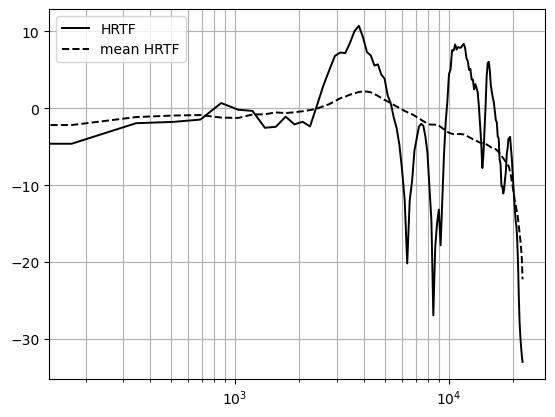

In [5]:
print(meanHRTFmag.shape)

freq=np.linspace(0, math.ceil(N/2), math.ceil(N/2)+1)*fs/N
figure()
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_L[11,4,:],'k',linewidth=1.4, label='HRTF')
plt.semilogx(freq,meanHRTFmag,'--k',linewidth=1.4, label='mean HRTF')
plt.grid(True, which="both", ls="-")
plt.legend()

In [6]:
# Compute mean spatial function over all frequencies and subjects 
meanHRTFmagnew_L=np.zeros(HRTFdata_full[0].HRTF_L.shape[0:2])
meanHRTFmagnew_R=np.zeros(HRTFdata_full[0].HRTF_L.shape[0:2])
for i in range(0, len(HRTFdata_full)): # for each subject
    meanHRTFmagnew_L = meanHRTFmagnew_L+np.squeeze(np.sum(HRTFdata_full[i].HRTFmag_Lnew,axis=2)) 
    meanHRTFmagnew_R = meanHRTFmagnew_R+np.squeeze(np.sum(HRTFdata_full[i].HRTFmag_Rnew,axis=2)) 
meanHRTFmagnew_L = meanHRTFmagnew_L/(len(HRTFdata_full)*HRTFdata_full[0].HRTFmag_Lnew.shape[2]) 
meanHRTFmagnew_R = meanHRTFmagnew_L/(len(HRTFdata_full)*HRTFdata_full[0].HRTFmag_Lnew.shape[2])
# remove mean spatial function
for i in range(0, len(HRTFdata_full)): # for each subject
    for j in range(0, HRTFdata_full[0].HRTFmag_Lnew.shape[2]):  # for each frequency
        HRTFdata_full[i].HRTFmag_Lnewnew[:,:,j] = np.squeeze(HRTFdata_full[i].HRTFmag_Lnew[:,:,j])-meanHRTFmagnew_L
        HRTFdata_full[i].HRTFmag_Rnewnew[:,:,j] = np.squeeze(HRTFdata_full[i].HRTFmag_Rnew[:,:,j])-meanHRTFmagnew_R

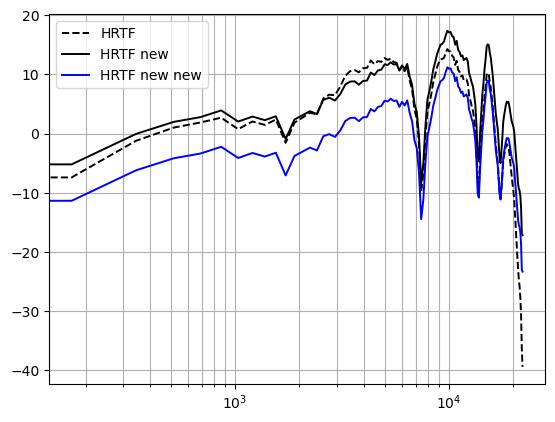

In [7]:
figure()
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_L[0,0,:],'--k',linewidth=1.4, label='HRTF')
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_Lnew[0,0,:],'k',linewidth=1.4, label='HRTF new')
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_Lnewnew[0,0,:],'b',linewidth=1.4, label='HRTF new new')
plt.grid(True, which="both", ls="-")
plt.legend()

In [16]:
## Estimate spatial principal components
# 2NS x D matrix of HRTFmag_newnew 
H_L=np.zeros((len(HRTFdata_full)*HRTFdata_full[0].HRTFmag_L.shape[2],HRTFdata_full[0].HRTFmag_Lnewnew.shape[0]*HRTFdata_full[0].HRTFmag_Lnewnew.shape[1]))
H_R=np.zeros((len(HRTFdata_full)*HRTFdata_full[0].HRTFmag_L.shape[2],HRTFdata_full[0].HRTFmag_Lnewnew.shape[0]*HRTFdata_full[0].HRTFmag_Lnewnew.shape[1]))
for i in range(0, len(HRTFdata_full)): 
    for k in range(0, HRTFdata_full[0].HRTF_L.shape[0]):
        for l in range(0, HRTFdata_full[0].HRTF_L.shape[1]):
            H_L[HRTFdata_full[0].HRTF_L.shape[2]*i:HRTFdata_full[0].HRTF_L.shape[2]*(i+1),HRTFdata_full[0].HRTF_L.shape[0]*l+k]=HRTFdata_full[i].HRTFmag_Lnewnew[k,l,:]   # Each column of H corresponds to a spatial direction, and each row of H represents the HRTF of an individual at a discrete frequency.
            H_R[HRTFdata_full[0].HRTF_L.shape[2]*i:HRTFdata_full[0].HRTF_L.shape[2]*(i+1),HRTFdata_full[0].HRTF_L.shape[0]*l+k]=HRTFdata_full[i].HRTFmag_Rnewnew[k,l,:]   # right ear
    print(i)
COV_L=np.cov(H_L.transpose()) # covariance matrix
COV_R=np.cov(H_R.transpose())
pass
eigen_valL, eigen_vecL = LA.eig(COV_L)
eigen_valR, eigen_vecR = LA.eig(COV_R)
var_L=np.zeros(eigen_vecL.shape[1])
var_R=np.zeros(eigen_vecL.shape[1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


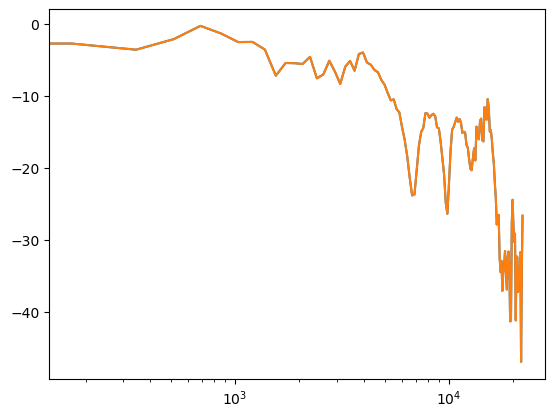

In [31]:
plt.semilogx(freq,H_R[0:129,0])
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_Rnewnew[0,0,:])

In [18]:
SPC_L=np.zeros(np.append(eigen_vecL.shape[0],HRTFdata_full[0].HRTFmag_Lnewnew.shape[0:2]))
SPC_R=np.zeros(np.append(eigen_vecL.shape[0],HRTFdata_full[0].HRTFmag_Lnewnew.shape[0:2]))
for k in range(0, HRTFdata_full[0].HRTF_L.shape[0]):
    for l in range(0, HRTFdata_full[0].HRTF_L.shape[1]):
        SPC_L[:,k,l]=eigen_vecL[:,k+l*HRTFdata_full[0].HRTF_L.shape[0]]
        SPC_R[:,k,l]=eigen_vecR[:,k+l*HRTFdata_full[0].HRTF_L.shape[0]]

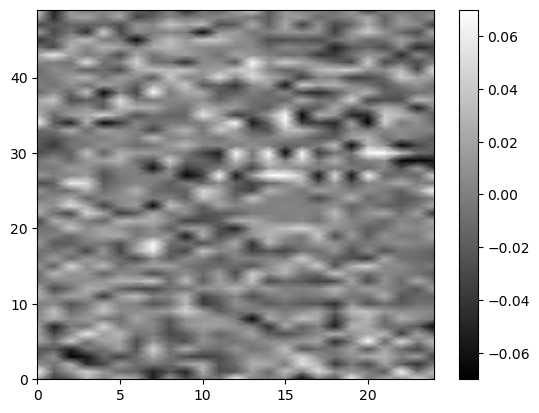

In [35]:
# Plot the covariance
fig, ax = plt.subplots()
X,Y = np.meshgrid(range(0, HRTFdata_full[0].HRTF_L.shape[0]),range(0, HRTFdata_full[0].HRTF_L.shape[1]))
surf = ax.pcolormesh(X,Y,np.squeeze(SPC_L[0,:,:]).transpose(), shading='gouraud', cmap=cm.gray, clim=(-0.07,0.07))

# Add a color bar which maps values to colors
fig.colorbar(surf)

# Show the plot
plt.show()

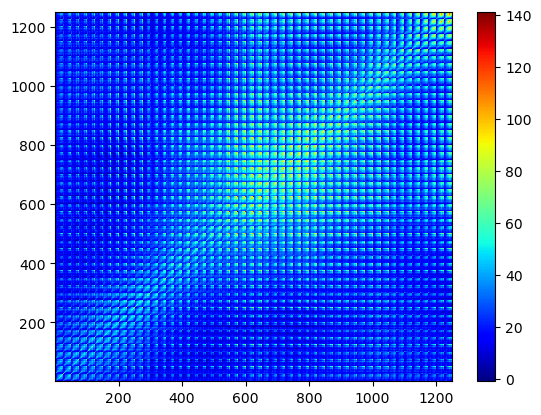

In [20]:
# Plot the covariance
fig, ax = plt.subplots()
X,Y = np.meshgrid(range(1,1251),range(1,1251))
surf = ax.pcolormesh(X,Y,COV_L, cmap=cm.jet)

# Add a color bar which maps values to colors
fig.colorbar(surf)

# Show the plot
plt.show()

(1250, 1250)


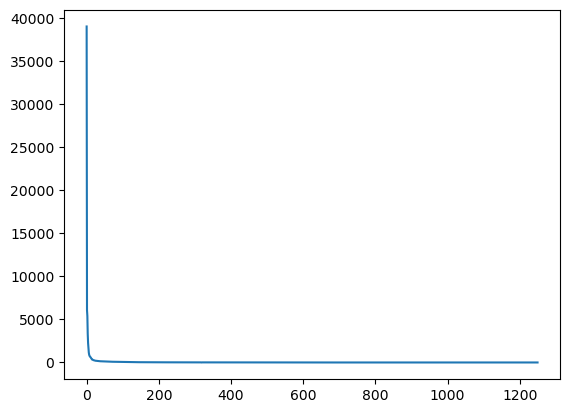

In [21]:
print(eigen_vecL.shape)
plt.plot(eigen_valL)

In [109]:
Hnew_L=np.zeros(np.append(H_L.shape,len(Nbases)))
Hnew_R=np.zeros(np.append(H_R.shape,len(Nbases)))
weights_L=np.matmul(H_L,eigen_vecL) 
weights_R=np.matmul(H_R,eigen_vecR) 

# Find strongest eigenvalues and decompose
for j in range(0,len(Nbases)):  
    synth_L = np.matmul(weights_L[:, 0:Nbases[j]],eigen_vecL[:, 0:Nbases[j]].transpose())  
    synth_R = np.matmul(weights_R[:, 0:Nbases[j]],eigen_vecR[:, 0:Nbases[j]].transpose())     

    for k in range(0, HRTFdata_full[0].HRTF_L.shape[0]): 
        for l in range(0, HRTFdata_full[0].HRTF_L.shape[1]):
            # restore removed parts
            Hnew_L[:,HRTFdata_full[0].HRTF_L.shape[0]*l+k,j] = synth_L[:,HRTFdata_full[0].HRTF_L.shape[0]*l+k] + meanHRTFmagnew_L[k,l] # add back the mean spatial function at each direction
            Hnew_R[:,HRTFdata_full[0].HRTF_L.shape[0]*l+k,j] = synth_R[:,HRTFdata_full[0].HRTF_L.shape[0]*l+k] + meanHRTFmagnew_R[k,l]
    print(j)
       
for i in range(0,len(eigen_valL)):# calculate cumulative variance
    var_L[i]=np.sum(eigen_valL[0:i+1])/np.sum(eigen_valL)
    var_R[i]=np.sum(eigen_valR[0:i+1])/np.sum(eigen_valR)

0
1
2
3
4
5
6
7
8
9


In [116]:
print(weights_L.shape)

(5805, 1250)


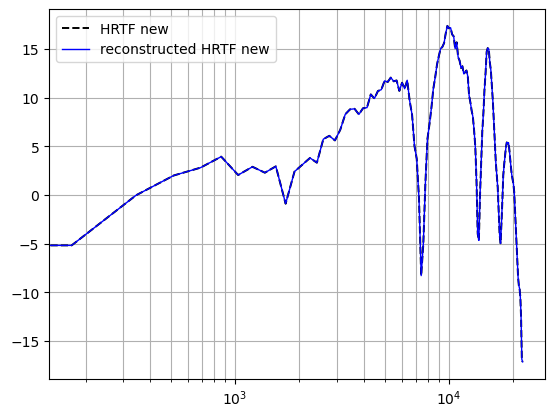

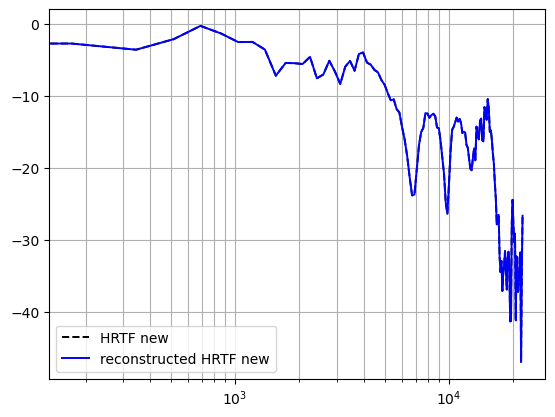

In [111]:
figure()
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_Lnew[0,0,:],'--k',linewidth=1.4, label='HRTF new')
plt.semilogx(freq,Hnew_L[0:129,0,9],'b',linewidth=1, label='reconstructed HRTF new')
plt.grid(True, which="both", ls="-")
plt.legend()

figure()
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_Rnewnew[0,0,:],'--k',linewidth=1.4, label='HRTF new')
plt.semilogx(freq,synth_R[0:129,0],'b',linewidth=1.4, label='reconstructed HRTF new')
plt.grid(True, which="both", ls="-")
plt.legend()

In [30]:
print(var_R[0:100])

[0.4555166  0.53073161 0.5984796  0.63755049 0.6655465  0.68768236
 0.70335529 0.71397517 0.72375169 0.73287248 0.74120668 0.74822042
 0.75406441 0.75957612 0.76459434 0.76935998 0.77338377 0.77712044
 0.78034445 0.78351662 0.7866481  0.78965657 0.79235416 0.79496364
 0.79747398 0.79997032 0.80237317 0.80469695 0.80698657 0.80919248
 0.81133591 0.81342854 0.81549998 0.8174939  0.81943549 0.82133782
 0.82321548 0.82506314 0.82688753 0.82863086 0.83040198 0.8321708
 0.83393142 0.83564158 0.83729773 0.83894244 0.84055841 0.84214023
 0.84368426 0.84522062 0.84672658 0.84820158 0.84965288 0.85108679
 0.85250347 0.85390242 0.85528236 0.85662384 0.85794732 0.85925605
 0.86055266 0.86182645 0.86310876 0.86435687 0.86560052 0.86682364
 0.86805406 0.86925495 0.87042652 0.87158385 0.87270865 0.8738233
 0.87493478 0.87602214 0.87709653 0.87816404 0.87922486 0.88026085
 0.88126472 0.88226175 0.88325014 0.88419815 0.88514433 0.88607671
 0.88699809 0.887905   0.88877358 0.88963912 0.89049726 0.891320

In [117]:
# save reconstructed HRTF
PCA_full=[]  # PCA_full is a list of instances HRTFSPCA
for i in range(0, len(HRTFdata_full)):
    PCAdata=HRTFSPCA()
    PCAdata.HRTFmag_Lsynth = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape),len(Nbases)))
    PCAdata.HRTFmag_Rsynth = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape),len(Nbases)))
    PCAdata.weights_L = np.zeros((HRTFdata_full[0].HRTF_L.shape[2],weights_L.shape[1]))
    PCAdata.weights_R = np.zeros((HRTFdata_full[0].HRTF_L.shape[2],weights_L.shape[1]))
    PCAdata.MSE_L = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape[0:2]),len(Nbases)))
    PCAdata.MSE_R = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape[0:2]),len(Nbases)))
    PCAdata.L2_L = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape[0:2]),len(Nbases)))
    PCAdata.L2_R = np.zeros(np.append(np.asarray(HRTFdata_full[0].HRTF_L.shape[0:2]),len(Nbases)))    
    for k in range(0, HRTFdata_full[0].HRTF_L.shape[0]):
        for l in range(0, HRTFdata_full[0].HRTF_L.shape[1]):
            PCAdata.weights_L = weights_L[HRTFdata_full[0].HRTF_L.shape[2]*i:HRTFdata_full[0].HRTF_L.shape[2]*(i+1),:]
            PCAdata.weights_R = weights_R[HRTFdata_full[0].HRTF_L.shape[2]*i:HRTFdata_full[0].HRTF_L.shape[2]*(i+1),:]
            for b in range(0, len(Nbases)):
                PCAdata.HRTFmag_Lsynth[k,l,:,b] =  Hnew_L[HRTFdata_full[0].HRTF_L.shape[2]*i:HRTFdata_full[0].HRTF_L.shape[2]*(i+1),HRTFdata_full[0].HRTF_L.shape[0]*l+k,b] + meanHRTFmag# add back the mean of subjects and frequencies
                PCAdata.HRTFmag_Rsynth[k,l,:,b] =  Hnew_R[HRTFdata_full[0].HRTF_L.shape[2]*i:HRTFdata_full[0].HRTF_L.shape[2]*(i+1),HRTFdata_full[0].HRTF_L.shape[0]*l+k,b] + meanHRTFmag

                SE_l = np.sum(np.square(PCAdata.HRTFmag_Lsynth[k,l,:,b] - np.squeeze(HRTFdata_full[i].HRTFmag_L[k,l,:])))
                SE_r = np.sum(np.square(PCAdata.HRTFmag_Rsynth[k,l,:,b] - np.squeeze(HRTFdata_full[i].HRTFmag_R[k,l,:])))
                MSE_l = (1/HRTFdata_full[0].HRTF_L.shape[2]) * SE_l
                MSE_r = (1/HRTFdata_full[0].HRTF_L.shape[2]) * SE_r
                L2_l = np.sqrt(SE_l)
                L2_r = np.sqrt(SE_r)
                PCAdata.MSE_L[k,l,b] = MSE_l     # in dB
                PCAdata.MSE_R[k,l,b] = MSE_r 
                PCAdata.L2_L[k,l,b] = L2_l       # in dB
                PCAdata.L2_R[k,l,b] = L2_r
    PCA_full.append(PCAdata)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


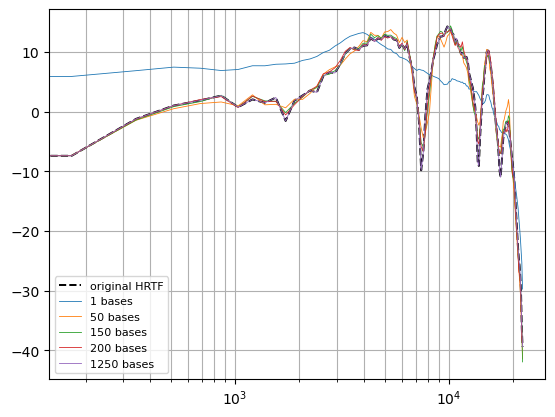

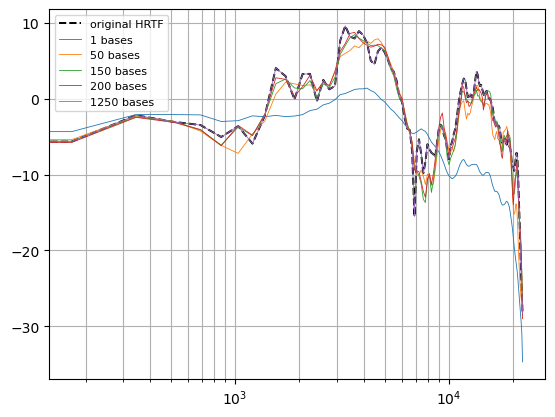

In [45]:
figure()
plt.semilogx(freq,HRTFdata_full[0].HRTFmag_L[0,0,:],'--k',linewidth=1.4, label='original HRTF')
for b in [0,2,4,5,9]:
    plt.semilogx(freq, PCA_full[0].HRTFmag_Lsynth[0,0,:,b],linewidth=0.6,label=str(Nbases[b])+' bases')
plt.legend(fontsize="8")
plt.grid(True, which="both", ls="-")

figure()
plt.semilogx(freq,HRTFdata_full[10].HRTFmag_R[10,10,:],'--k',linewidth=1.4, label='original HRTF')
for b in [0,2,4,5,9]:
    plt.semilogx(freq, PCA_full[10].HRTFmag_Rsynth[10,10,:,b],linewidth=0.6,label=str(Nbases[b])+' bases')
plt.legend(fontsize="8")
plt.grid(True, which="both", ls="-")

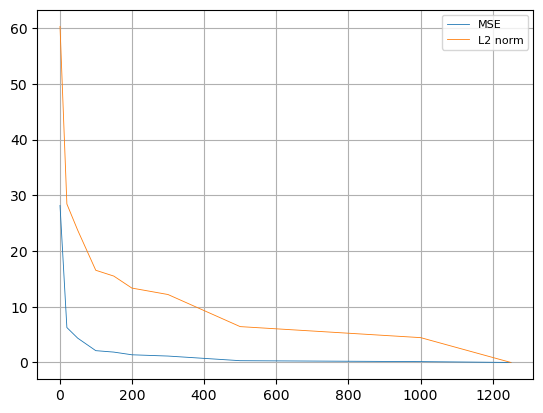

In [52]:
holdMSE=ndarray((len(Nbases)))
holdL2=ndarray((len(Nbases)))   
for b in range(0,len(Nbases)):
    holdMSE[b]=PCA_full[40].MSE_L[1,1,b]
    holdL2[b]=PCA_full[40].L2_L[1,1,b]
plt.plot(Nbases, holdMSE,linewidth=0.6,label='MSE')
plt.plot(Nbases, holdL2,linewidth=0.6,label='L2 norm')
plt.grid(True)
plt.legend(fontsize="8")

In [95]:
## Key anthropometric parameters selection 
class anthdataclass:
    def __init__(self):
        self.subj=[]
        self.parameters=[]

data_dir = pjoin('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/anthropometry/')
mat_fname = pjoin(data_dir, 'anthro.mat')
anth_data=sio.loadmat(mat_fname)

subj=anth_data.get('id')
X=anth_data.get('X')
D=anth_data.get('D')

indnan=np.argwhere(np.isnan(X[:,11]))
uni_indnan=list(set(indnan[:,0]))

subj=np.delete(subj,uni_indnan,axis=0)
X=np.delete(X,uni_indnan,axis=0)
D=np.delete(D,uni_indnan,axis=0)

adata=[]
for i in range(0, len(subj)):
    anth=anthdataclass()
    anth.subj=subj[i]
    anth.parameters=np.zeros((9,2))
    anth.parameters[0,0]=X[i,0]
    anth.parameters[1,0]=X[i,3]
    anth.parameters[2,0]=X[i,11]
    anth.parameters[3,0]=D[i,0]
    anth.parameters[4,0]=D[i,2]
    anth.parameters[5,0]=D[i,3]
    anth.parameters[6,0]=D[i,4]
    anth.parameters[7,0]=D[i,5]

    anth.parameters[0,1]=X[i,0]
    anth.parameters[1,1]=X[i,3]
    anth.parameters[2,1]=X[i,11]
    anth.parameters[3,1]=D[i,8]
    anth.parameters[4,1]=D[i,10]
    anth.parameters[5,1]=D[i,11]
    anth.parameters[6,1]=D[i,12]
    anth.parameters[7,1]=D[i,13]

    adata.append(anth)

In [134]:
print(adata[0].parameters[0])

[16.18117203 16.18117203]


In [121]:
## Individual HRTF modelling using DNN
# 0. data preparation
for j in sorted(uni_indnan, reverse=True):
   del PCA_full[j]


IndexError: list assignment index out of range

In [128]:
# split front and rear directions
data_front = np.zeros((2*len(PCA_full),PCA_full[0].HRTFmag_Lsynth.shape[2],int(PCA_full[0].weights_L.shape[1]/2)))
data_rear = np.zeros((2*len(PCA_full),PCA_full[0].HRTFmag_Lsynth.shape[2],int(PCA_full[0].weights_L.shape[1]/2)))
for i in range(0, len(PCA_full)):
    data_front[i,:]=PCA_full[i].weights_L[:,0:int(weights_L.shape[1]/2)]
    data_front[len(PCA_full)+i,:]=PCA_full[i].weights_R[:,0:int(weights_L.shape[1]/2)]
    data_rear[i,:]=PCA_full[i].weights_L[:,int(weights_L.shape[1]/2):]
    data_rear[len(PCA_full)+i,:]=PCA_full[i].weights_R[:,int(weights_L.shape[1]/2):]


In [129]:
print(data_front.shape)

(74, 129, 625)


In [135]:
# 1. model SPCA weights
x_train=np.zeros(30,8)
y_train=np.zeros(30,2,20)
for i in range (0,30):
    x_train[i,:]=adata[i].parameters[:,0]
    x_train[i+30,:]=adata[i].parameters[:,1]
    y_train[i,:,:]=data_front[i,:,:]
    y_train[i+30,:,:]=data_front[i+30,:,:]
# define the keras model
model = Sequential()
model.add(Dense(20, input_shape=(8,), activation='tanh')) # Fully connected layers are defined using the Dense class
model.add(Dense(y_train.shape[2], activation='tanh'))

# compile the keras model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

#for j in range(0,x_train.shape[1]):
# fit the keras model on the dataset
model.fit(x_train, np.squeeze(y_train[:,0,:]), epochs=1000, batch_size=10)   # builds the model for the first time

# evaluate the keras model
#_, accuracy = model.evaluate(x_train, y_train)
#_, accuracy = model.evaluate(x_valid, y_valid)

TypeError: list indices must be integers or slices, not tuple

In [94]:
print()

<class 'list'>
